In [ ]:
import gymnasium as gym
import numpy as np

# Create Gym
env = gym.make("LunarLander-v3", render_mode="rgb_array")

state, _ = env.reset() # starts a new episode and gives the initial state.

print("Initial State:", state)
print("State shape:", state.shape)
print("Action Space:", env.action_space)
print("Action Space Type:", type(env.action_space))
print("Number of Actions:", env.action_space.n)


Initial State: [ 0.00260715  1.4197427   0.26406005  0.39211994 -0.00301424 -0.05981351
  0.          0.        ]
State shape: (8,)
Action Space: Discrete(4)
Action Space Type: <class 'gymnasium.spaces.discrete.Discrete'>
Number of Actions: 4


: 

In [ ]:
import torch
import torch.nn as nn

# Actor network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128), # It's a fully connected layer and is an INPUT layer.
            nn.ReLU(), # Rectified Linear Unit is a Hidden Layer. It adds non-linearity so the network can learn more complex patterns.
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)  # The softmax function turns a list of raw numbers (called logits) into probabilities.
        )
    
    def forward(self, state):
        return self.model(state)

# Critic network
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # gives us single Scalar value
        )
    
    def forward(self, state):
        return self.model(state)


In [4]:
# Get dimensions from environment
state_dim = env.observation_space.shape[0]   # 8
action_dim = env.action_space.n              # 4

# Initialize networks
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)

# Convert the initial state to a PyTorch tensor
state_tensor = torch.tensor(state, dtype=torch.float32)

# Get outputs
action_probs = actor(state_tensor)
state_value = critic(state_tensor)

# Print results
print("Action probabilities:", action_probs.detach().numpy())
print("Sum of probabilities (should be ~1):", action_probs.sum().item())
print("State value estimate:", state_value.item())


Action probabilities: [0.2855493  0.26307684 0.21977732 0.23159653]
Sum of probabilities (should be ~1): 1.0
State value estimate: 0.06183847039937973


In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
gamma = 0.99
learning_rate = 1e-3
num_episodes = 4500

# Optimizers
actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate)

# For plotting
episode_rewards = []

In [ ]:
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32)

        # Get action probabilities and sample an action
        action_probs = actor(state_tensor)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        # Take the action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action.item()) # The underscore (_) ignores any additional information that is returned.
        done = terminated or truncated
        total_reward += reward

        # Convert next state to tensor
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32)

        # Compute value estimates
        value = critic(state_tensor)
        next_value = critic(next_state_tensor).detach()  # Don't backpropagate through next value

        # Compute advantage
        advantage = reward + (gamma * next_value * (1 - int(done))) - value

        # Critic update (MSE loss)
        critic_loss = advantage.pow(2).mean()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Actor update (policy gradient loss)
        actor_loss = -dist.log_prob(action) * advantage.detach()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Move to next state
        state = next_state

    episode_rewards.append(total_reward)

    # Print progress every 10 episodes
    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        print(f"Episode {episode+1}/{num_episodes} - Avg Reward: {avg_reward:.2f}")


Episode 10/4500 - Avg Reward: -239.06
Episode 20/4500 - Avg Reward: -173.91
Episode 30/4500 - Avg Reward: -257.14
Episode 40/4500 - Avg Reward: -108.30
Episode 50/4500 - Avg Reward: -181.90
Episode 60/4500 - Avg Reward: -85.67
Episode 70/4500 - Avg Reward: 14.00
Episode 80/4500 - Avg Reward: 25.78
Episode 90/4500 - Avg Reward: 8.31
Episode 100/4500 - Avg Reward: -5.07
Episode 110/4500 - Avg Reward: -71.01
Episode 120/4500 - Avg Reward: -84.78
Episode 130/4500 - Avg Reward: -114.54
Episode 140/4500 - Avg Reward: -106.73
Episode 150/4500 - Avg Reward: -125.88
Episode 160/4500 - Avg Reward: -241.51
Episode 170/4500 - Avg Reward: -227.07
Episode 180/4500 - Avg Reward: -242.13
Episode 190/4500 - Avg Reward: -145.85
Episode 200/4500 - Avg Reward: -128.99
Episode 210/4500 - Avg Reward: -137.44
Episode 220/4500 - Avg Reward: -144.37
Episode 230/4500 - Avg Reward: -178.77
Episode 240/4500 - Avg Reward: -204.14
Episode 250/4500 - Avg Reward: -228.22
Episode 260/4500 - Avg Reward: -247.48
Episode

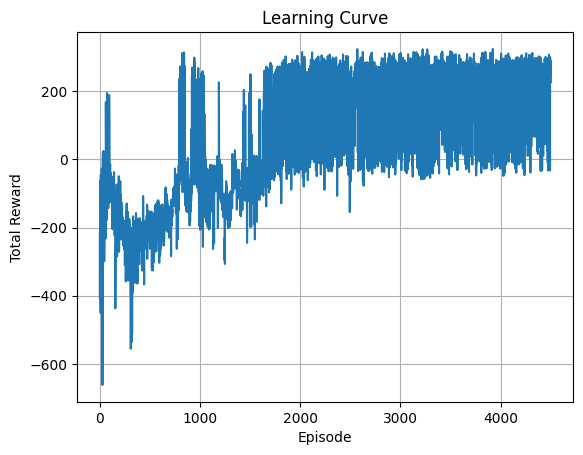

In [7]:
# Plot the learning curve
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Learning Curve")
plt.grid()
plt.show()

#### The agent learns progressively: it starts off with poor performance but eventually stabilizes around a high reward.

The learning curve smooths out as the policy improves.

A consistent reward near 200+ implies the agent is landing the lunar module successfully most of the time.

In [ ]:
# Evaluation
num_eval_episodes = 4500
eval_rewards = []

for ep in range(num_eval_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            action_probs = actor(state_tensor)
        action = torch.argmax(action_probs).item() # It's choosing the most probable action (greedy choice)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state

    eval_rewards.append(total_reward)
    print(f"Evaluation Episode {ep+1}: Total Reward = {total_reward:.2f}")

avg_eval_reward = np.mean(eval_rewards)
print(f"\nAverage Evaluation Reward over {num_eval_episodes} episodes: {avg_eval_reward:.2f}")


Evaluation Episode 1: Total Reward = 261.27
Evaluation Episode 2: Total Reward = 283.06
Evaluation Episode 3: Total Reward = 245.85
Evaluation Episode 4: Total Reward = 39.61
Evaluation Episode 5: Total Reward = 263.60
Evaluation Episode 6: Total Reward = 224.19
Evaluation Episode 7: Total Reward = 38.99
Evaluation Episode 8: Total Reward = 134.96
Evaluation Episode 9: Total Reward = 290.02
Evaluation Episode 10: Total Reward = 51.17
Evaluation Episode 11: Total Reward = 229.71
Evaluation Episode 12: Total Reward = 19.41
Evaluation Episode 13: Total Reward = 245.86
Evaluation Episode 14: Total Reward = 261.38
Evaluation Episode 15: Total Reward = 1.38
Evaluation Episode 16: Total Reward = 243.50
Evaluation Episode 17: Total Reward = 273.44
Evaluation Episode 18: Total Reward = 274.20
Evaluation Episode 19: Total Reward = 250.44
Evaluation Episode 20: Total Reward = 266.97
Evaluation Episode 21: Total Reward = 282.39
Evaluation Episode 22: Total Reward = -62.22
Evaluation Episode 23: To

In [9]:
# Random policy baseline
random_rewards = []

for ep in range(num_eval_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state

    random_rewards.append(total_reward)

avg_random_reward = np.mean(random_rewards)
print(f"Average Random Policy Reward over {num_eval_episodes} episodes: {avg_random_reward:.2f}")


Average Random Policy Reward over 4500 episodes: -182.05


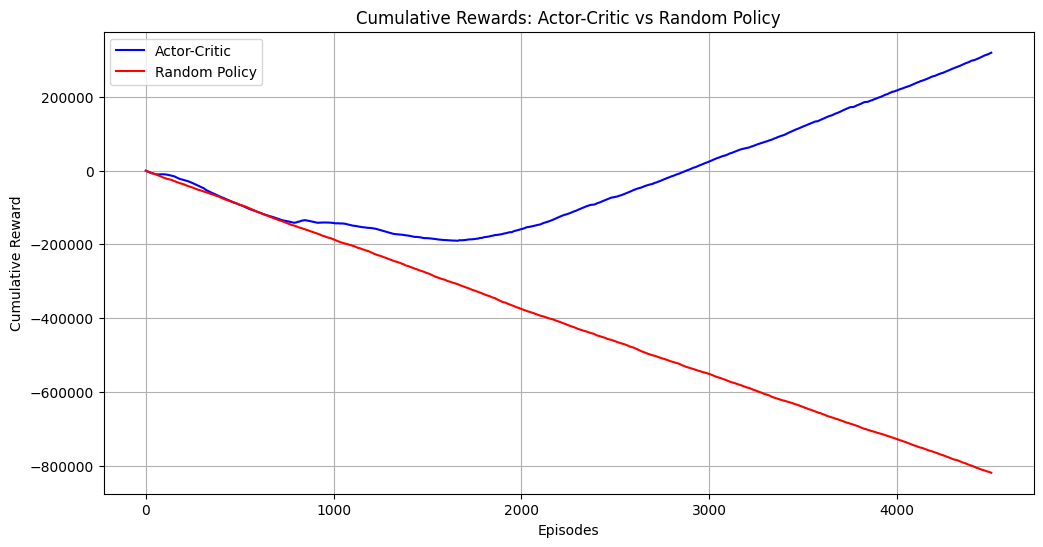

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Compute cumulative rewards
cumulative_actor_critic = np.cumsum(episode_rewards)
cumulative_random = np.cumsum(random_rewards)

# Episode ranges
episodes_ac = range(1, len(cumulative_actor_critic) + 1)
episodes_random = range(1, len(cumulative_random) + 1)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(episodes_ac, cumulative_actor_critic, color='blue', label='Actor-Critic')
plt.plot(episodes_random, cumulative_random, color='red', label='Random Policy')

# Labels and title
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards: Actor-Critic vs Random Policy')
plt.legend()
plt.grid(True)
plt.show()


#### The agent trained by implementing actor-critic algorithm was able to land the lunar module successfully most of the time 

### 1. Actor-Critic Learns from Experience
The actor learns which actions lead to higher rewards.

The critic evaluates how good the current state is.

Over time, it updates both networks to get better at choosing smart actions and avoiding bad ones.

🔁 The more it plays, the better decisions it makes based on what it has learned.

### Random Policy Has No Learning
A random policy chooses actions blindly.

It has no memory, learning, or improvement.

So sometimes it does okay by chance, but often it fails badly.

🎲 Random actions can crash the lander or miss rewards.